# ETF Analysis Project

In this project, we analyze a selection of **Vanguard ETFs** with the goal of building a $10,000 portfolio 
that balances **growth potential** and **risk management**.

We will:
1. Download 5 years of ETF data from Yahoo Finance
2. Calculate basic statistics (returns, volatility, skewness, kurtosis, min/max)
3. Run a Monte Carlo simulation to project possible outcomes after 1 year
4. Visualize results and draw insights

## Functions

Here we define reusable Python functions for:
- Downloading data (`yfinance`)
- Calculating distribution statistics
- Running Monte Carlo simulations
- Summarizing and plotting results

In [36]:
# %% Imports
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
import math

In [37]:
#---------------------------------- Functions for the Script -----------------------------------------#
def get_data(ticker, start, end ):
    stock_data = yf.download(ticker, start, end, auto_adjust=False)['Adj Close']
    return stock_data


def calc_basic_stats(stock_data):
    ''' Function to calculate basic distribution statistics'''
    ticker_returns = stock_data.pct_change().dropna()
    stats__dict_df = pd.DataFrame({
        "Average Returns (Annualized)": ticker_returns.mean() * 252,
        "Volatility (Annualized)": ticker_returns.std() * np.sqrt(252),
        "Skewness": stats.skew(ticker_returns),      
        "Kurtosis": stats.kurtosis(ticker_returns),
        "Min Return": ticker_returns.min(),
        "Max Return": ticker_returns.max()
    })
    return stats__dict_df.round(4)

# -------------------------------- Monte Carlo Simulation Functions -----------------------------#
def monte_carlo_sim(stock_data, initial_value, iterations, time_horizon, freq='daily'):
    """ Function to run simple monte carlo simulation """

    ticker_returns = stock_data.pct_change().dropna()  

    # Map Frequency
    freq_map = {'daily':252, 'weekly': 52, 'monthly':12}
    steps = freq_map[freq]

    # Annualized statistics
    mean_returns_annualized = ticker_returns.mean() * 252
    volatility = ticker_returns.std() * np.sqrt(252)

    # Convert annual metrics to correct frequency
    mean_returns_period = (1 + mean_returns_annualized)**(1/steps) - 1
    volatility_period = volatility / np.sqrt(steps)

    results = np.zeros((time_horizon, iterations))

    for i in range(iterations):
        random_returns = np.random.normal(loc=mean_returns_period ,scale=volatility_period ,size=time_horizon)
    
        # Calculate portfilio value 
        price_path = initial_value * np.cumprod(1 + random_returns)
        results[:,i] = price_path
    return results


def analyze_monte_carlo(sim_results, initial_value):
    """Analyze Monte Carlo simulation results (focus on final values)"""
    # Use only final simulated values (last row of results)
    final_values = sim_results[-1, :]
    
    mc_stats = {
        'Expected Value': np.mean(final_values),
        'Median Value': np.median(final_values),
        'Probability of Loss': np.mean(final_values < initial_value)
    }
    # Round only at the end if needed
    mc_stats = {key: float(round(value,4)) for key, value in mc_stats.items()}
    return mc_stats



def plot_simulation(sim_results, ticker, freq):
    '''Simulation plots'''
    plt.figure(figsize=(10, 6))
    plt.plot(sim_results, alpha=0.5)
    plt.title(f"{ticker} Monte Carlo Simulation ({freq})")
    plt.xlabel("Time Steps")
    plt.ylabel("Portfolio Value")
    plt.grid(True)
    plt.show()




## Setup

We define the list of ETFs, the time period for analysis, 
and parameters for the Monte Carlo simulation.

In [38]:
#------------------------------------------- Setup ----------------------------#
etf_tickers = ['VUG','MGK','VONG','VGT','VOOG','VTI']
start_date = '2020-01-01'
end_date = '2024-12-31'
mc_initial_val = 10000
time_horizon = 252
simulations = 1000 # same as iteration 

## ETF Analysis

For each ETF:
1. Calculate statistics
2. Run Monte Carlo simulation
3. Store and merge results


In [39]:
ticker_stats_list = []
mc_stats_list = []

for ticker in etf_tickers:
    stock_data = get_data(ticker, start_date, end_date)

    # Basic stats
    ticker_stats = calc_basic_stats(stock_data)
    ticker_stats["Ticker"] = ticker
    ticker_stats_list.append(ticker_stats)

    sim_results = monte_carlo_sim(stock_data, mc_initial_val, simulations, time_horizon)
    sim_summary = analyze_monte_carlo(sim_results, mc_initial_val)
    sim_summary["Ticker"] = ticker
    mc_stats_list.append(sim_summary)
    #plot_simulation(sim_results, ticker, time_horizon)
    
all_ticker_stats = pd.concat(ticker_stats_list, ignore_index=True)
all_mc_stats = pd.DataFrame(mc_stats_list)
merged_df = pd.merge(all_ticker_stats, all_mc_stats, 'left','Ticker')
    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


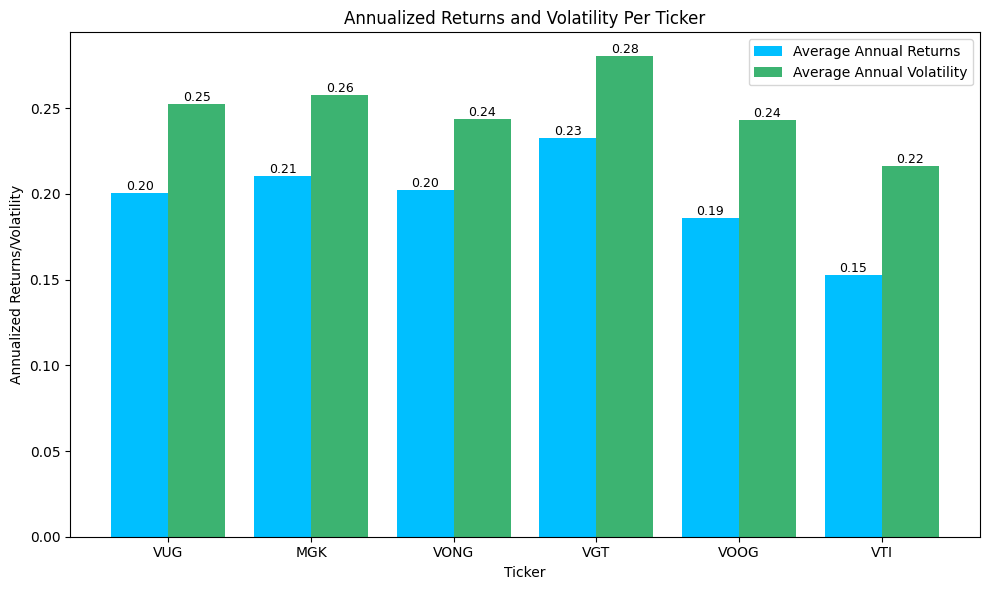

In [40]:
bar_width, x = 0.4, np.arange(len(etf_tickers))

plt.figure(figsize=(10,6))
# Grouped Bar Plot 
bars1 = plt.bar(x - bar_width/2, merged_df['Average Returns (Annualized)'], bar_width, label='Average Annual Returns', color='deepskyblue')
bars2 = plt.bar(x + bar_width/2, merged_df['Volatility (Annualized)'], bar_width, label='Average Annual Volatility', color='mediumseagreen')

plt.xticks(x,etf_tickers)
plt.xlabel("Ticker")
plt.ylabel("Annualized Returns/Volatility")
plt.title("Annualized Returns and Volatility Per Ticker")
plt.legend()
# Add values on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
plt.tight_layout()
plt.show()

In [41]:
final_summary_df = merged_df[['Ticker'
                              ,'Average Returns (Annualized)'
                              ,'Volatility (Annualized)'
                              ,'Expected Value'
                              ,'Median Value'
                              ,'Probability of Loss'
                              ]]

final_summary_df

,Ticker,Average Returns (Annualized),Volatility (Annualized),Expected Value,Median Value,Probability of Loss
0,VUG,0.2004,0.2526,12006.7932,11593.8857,0.275
1,MGK,0.2104,0.2577,12064.5900,11653.1462,0.273
2,VONG,0.2025,0.2437,12150.9998,11892.1779,0.262
3,VGT,0.2327,0.2802,12319.3007,11863.6329,0.256
4,VOOG,0.1860,0.2428,11764.9835,11393.9325,0.295
5,VTI,0.1525,0.2161,11453.5172,11205.8814,0.298


[*********************100%***********************]  6 of 6 completed


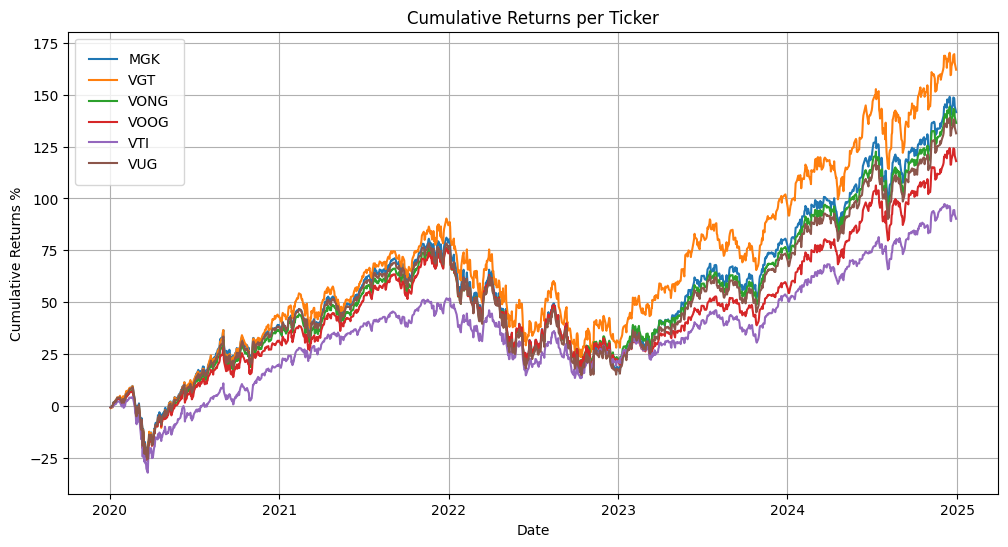

In [42]:
stock_data = get_data(etf_tickers, start_date, end_date)
returns = stock_data.pct_change()

# Calculate the cumulative return for each ticker
cumulative_returns = ((1 + returns).cumprod() - 1 ) * 100

plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label=etf_tickers)
plt.grid(True)
plt.legend(stock_data.columns,fancybox=True, borderpad=1)
plt.title("Cumulative Returns per Ticker")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns %")
plt.show()

[*********************100%***********************]  6 of 6 completed


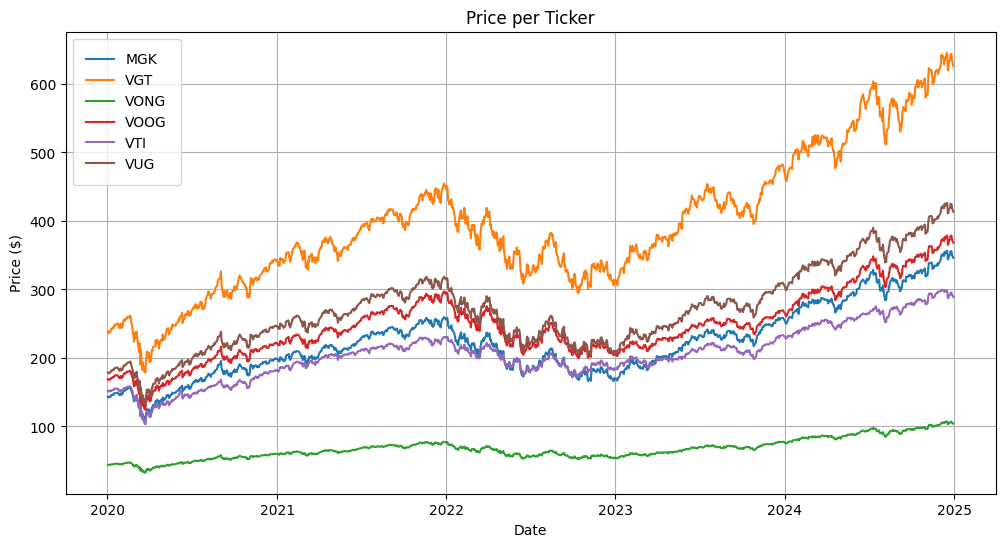

In [43]:
stock_data = get_data(etf_tickers, start_date, end_date)

# Plot the prices 
plt.figure(figsize=(12,6))
plt.plot(stock_data)
plt.grid(True)
plt.legend(stock_data.columns,fancybox=True, borderpad=1)
plt.title("Price per Ticker")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


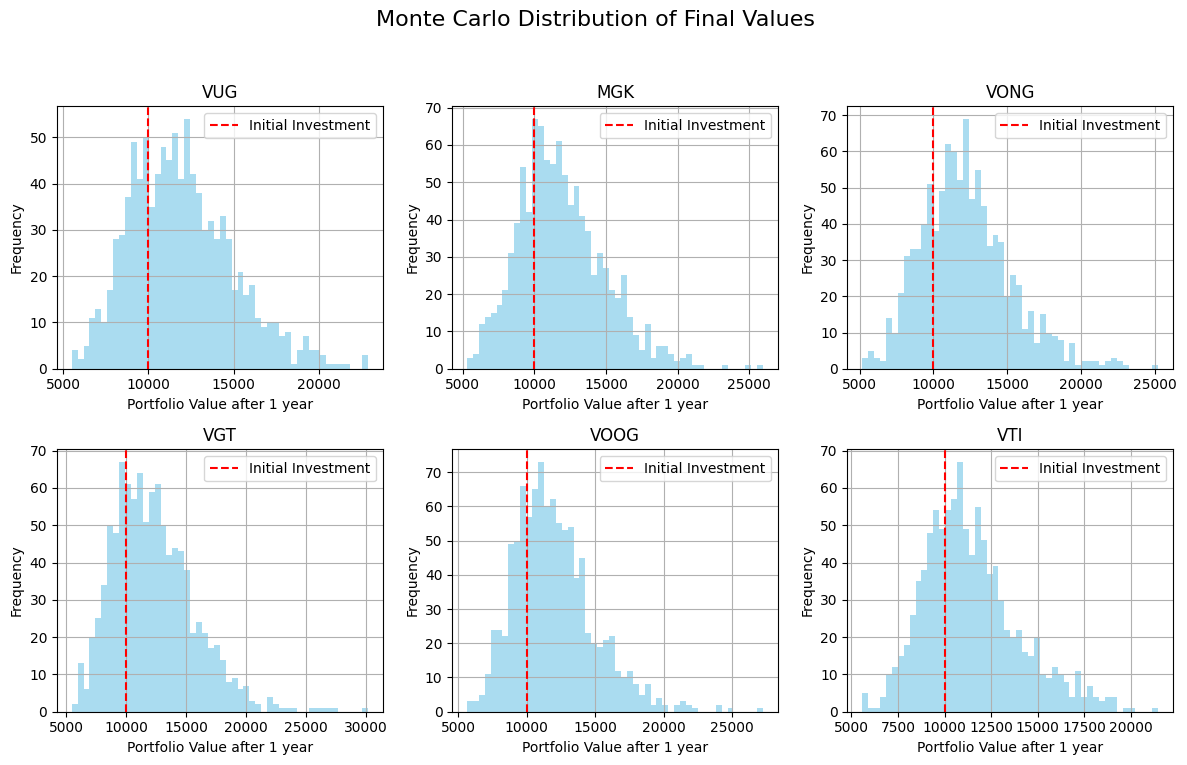

In [54]:
# Monte Carlo Final Value Distribution (Example for each ETF)

# Number of Tickers
n = len(etf_tickers)

# Decide subplot grid (3 columns)
cols = 3
rows = math.ceil(n/cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))

# Flatten axes for each iteration 
axes = axes.flatten()

for i, ticker in enumerate(etf_tickers):
    stock_data = get_data(ticker, start_date, end_date)
    sim_results = monte_carlo_sim(stock_data, mc_initial_val, simulations, time_horizon)
    final_values = sim_results[-1, :]

    ax = axes[i]
    ax.hist(final_values, bins=50, alpha=0.7, color="skyblue")
    ax.axvline(mc_initial_val, color="red", linestyle="--", label="Initial Investment")
    ax.set_title(ticker)
    ax.set_xlabel("Portfolio Value after 1 year")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.grid(True)

fig.suptitle("Monte Carlo Distribution of Final Values", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for suptitle
plt.show()
